### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import networks_cifar as networks
import utils
import biased_sampler
    
%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 1        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
# Ensure reproducibility
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

### Load dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

cifar_image_shape = (32, 32, 3)
# Student trained without data augmentation
transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )

train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR_dataset/', train=True, 
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR_dataset/', train=False, 
                                            download=True, transform=transform)

num_train = int(1.0 * len(train_val_dataset) * 95 / 100)
num_val = len(train_val_dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
batch_size = 128
num_class = 10
class_prob = [0.0 for _ in range(num_class)]
class_prob[7] = 0.5
class_prob[8] = 0.5

train_val_biased_sampler = biased_sampler.CIFARClassBiasedSampler(train_val_dataset, class_prob)
train_biased_sampler = biased_sampler.CIFARClassBiasedSampler(train_dataset, class_prob)

train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=128, 
                                                sampler=train_val_biased_sampler, 
                                                num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                            sampler=train_biased_sampler, 
                                            num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [8]:
checkpoints_path_teacher = 'CIFAR_checkpoints_teacher/'
checkpoints_path_student = 'CIFAR_checkpoints_student_biased/'
summaries_path_student = 'CIFAR_summaries_student_biased/'
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)
if not os.path.exists(summaries_path_student):
    os.makedirs(summaries_path_student)

### Load teacher network

In [9]:
# set the hparams used for training teacher to load the teacher network
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# keeping dropout input = dropout hidden
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['dropout_input'] = hparam_tuple[0][0]
    hparam['dropout_hidden'] = hparam_tuple[0][1]
    hparam['weight_decay'] = hparam_tuple[1]
    hparam['lr_decay'] = hparam_tuple[2]
    hparam['momentum'] = hparam_tuple[3]
    hparam['lr'] = hparam_tuple[4]
    hparams_list.append(hparam)
    
load_path = checkpoints_path_teacher + utils.hparamToString(hparams_list[0]) + '.tar'
teacher_net = networks.TeacherNetwork(cifar_image_shape, num_class)
teacher_net.load_state_dict(torch.load(load_path, map_location=fast_device)['model_state_dict'])
teacher_net = teacher_net.to(fast_device)

In [10]:
# Calculate teacher test accuracy
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('teacher test accuracy: ', test_accuracy)

teacher test accuracy:  0.6128


### Train student network without distillation

In [11]:
num_epochs = 10
print_every = 100

In [12]:
temperatures = [1]    # temperature for distillation loss
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [0.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# No dropout used
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_no_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetworkLarge(cifar_image_shape, num_class)
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_no_distill[hparam_tuple] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                    train_loader, val_loader, 
                                                                    print_every=print_every, 
                                                                    fast_device=fast_device)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_no_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)

Training with hparamsT=1, alpha=0.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.078
[1,   100/  372] train loss: 0.191 train accuracy: 0.961
[1,   200/  372] train loss: 0.193 train accuracy: 0.922
[1,   300/  372] train loss: 0.107 train accuracy: 0.977
epoch: 1 validation accuracy: 0.174
[2,   100/  372] train loss: 0.083 train accuracy: 0.984
[2,   200/  372] train loss: 0.122 train accuracy: 0.969
[2,   300/  372] train loss: 0.045 train accuracy: 0.992
epoch: 2 validation accuracy: 0.176
[3,   100/  372] train loss: 0.061 train accuracy: 0.984
[3,   200/  372] train loss: 0.034 train accuracy: 0.992
[3,   300/  372] train loss: 0.011 train accuracy: 1.000
epoch: 3 validation accuracy: 0.181
[4,   100/  372] train loss: 0.022 train accuracy: 0.992
[4,   200/  372] train loss: 0.066 train accuracy: 0.969
[4,   300/  372] train loss: 0.026 train accuracy: 0.984
epoch: 4 validation accuracy: 0.177
[5,

In [13]:
# Calculate student test accuracy
_, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
print('student test accuracy (w/o distillation): ', test_accuracy)

student test accuracy (w/o distillation):  0.1859


### Hyperparameter search utils

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
weight_decay_scatter = ([math.log10(h['weight_decay']) if h['weight_decay'] > 0 else -6 for h in hparams_list])
dropout_scatter = [int(h['dropout_input'] == 0.2) for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_no_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(weight_decay_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(weight_decay_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (weight_decay_scatter[i], dropout_scatter[i]))
plt.show()

### Train student network using distillation

#### Effect of Temperature

In [14]:
num_epochs = 20
print_every = 100

In [15]:
temperatures = [1, 2, 5, 10, 15, 20]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [1.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetworkLarge(cifar_image_shape, num_class)
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_distill[hparam_tuple] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                train_loader, val_loader, 
                                                                print_every=print_every, 
                                                                fast_device=fast_device)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)


Training with hparamsT=1, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.078
[1,   100/  372] train loss: 0.364 train accuracy: 0.938
[1,   200/  372] train loss: 0.365 train accuracy: 0.914
[1,   300/  372] train loss: 0.261 train accuracy: 0.984
epoch: 1 validation accuracy: 0.183
[2,   100/  372] train loss: 0.220 train accuracy: 0.961
[2,   200/  372] train loss: 0.230 train accuracy: 0.969
[2,   300/  372] train loss: 0.161 train accuracy: 0.969
epoch: 2 validation accuracy: 0.232
[3,   100/  372] train loss: 0.181 train accuracy: 0.945
[3,   200/  372] train loss: 0.163 train accuracy: 0.961
[3,   300/  372] train loss: 0.146 train accuracy: 0.938
epoch: 3 validation accuracy: 0.266
[4,   100/  372] train loss: 0.132 train accuracy: 0.938
[4,   200/  372] train loss: 0.108 train accuracy: 0.953
[4,   300/  372] train loss: 0.131 train accuracy: 0.945
epoch: 4 validation accuracy: 0.292
[5,

epoch: 18 validation accuracy: 0.432
[19,   100/  372] train loss: 0.026 train accuracy: 0.922
[19,   200/  372] train loss: 0.021 train accuracy: 0.875
[19,   300/  372] train loss: 0.023 train accuracy: 0.914
epoch: 19 validation accuracy: 0.434
[20,   100/  372] train loss: 0.022 train accuracy: 0.906
[20,   200/  372] train loss: 0.022 train accuracy: 0.859
[20,   300/  372] train loss: 0.021 train accuracy: 0.945
epoch: 20 validation accuracy: 0.435
Training with hparamsT=5, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
epoch: 0 validation accuracy: 0.078
[1,   100/  372] train loss: 1.861 train accuracy: 0.945
[1,   200/  372] train loss: 1.237 train accuracy: 0.914
[1,   300/  372] train loss: 1.018 train accuracy: 0.977
epoch: 1 validation accuracy: 0.258
[2,   100/  372] train loss: 0.728 train accuracy: 0.906
[2,   200/  372] train loss: 0.644 train accuracy: 0.938
[2,   300/  372] train loss: 0.498 train accuracy: 

[16,   300/  372] train loss: 0.016 train accuracy: 0.883
epoch: 16 validation accuracy: 0.465
[17,   100/  372] train loss: 0.017 train accuracy: 0.883
[17,   200/  372] train loss: 0.017 train accuracy: 0.875
[17,   300/  372] train loss: 0.013 train accuracy: 0.930
epoch: 17 validation accuracy: 0.465
[18,   100/  372] train loss: 0.014 train accuracy: 0.891
[18,   200/  372] train loss: 0.011 train accuracy: 0.883
[18,   300/  372] train loss: 0.014 train accuracy: 0.930
epoch: 18 validation accuracy: 0.466
[19,   100/  372] train loss: 0.014 train accuracy: 0.922
[19,   200/  372] train loss: 0.011 train accuracy: 0.883
[19,   300/  372] train loss: 0.010 train accuracy: 0.930
epoch: 19 validation accuracy: 0.466
[20,   100/  372] train loss: 0.012 train accuracy: 0.906
[20,   200/  372] train loss: 0.012 train accuracy: 0.859
[20,   300/  372] train loss: 0.011 train accuracy: 0.945
epoch: 20 validation accuracy: 0.466
Training with hparamsT=15, alpha=1.0, dropout_hidden=0.0, dro

[14,   200/  372] train loss: 0.021 train accuracy: 0.883
[14,   300/  372] train loss: 0.019 train accuracy: 0.891
epoch: 14 validation accuracy: 0.463
[15,   100/  372] train loss: 0.019 train accuracy: 0.930
[15,   200/  372] train loss: 0.019 train accuracy: 0.852
[15,   300/  372] train loss: 0.019 train accuracy: 0.945
epoch: 15 validation accuracy: 0.465
[16,   100/  372] train loss: 0.016 train accuracy: 0.859
[16,   200/  372] train loss: 0.017 train accuracy: 0.883
[16,   300/  372] train loss: 0.015 train accuracy: 0.875
epoch: 16 validation accuracy: 0.465
[17,   100/  372] train loss: 0.017 train accuracy: 0.891
[17,   200/  372] train loss: 0.014 train accuracy: 0.875
[17,   300/  372] train loss: 0.013 train accuracy: 0.914
epoch: 17 validation accuracy: 0.466
[18,   100/  372] train loss: 0.013 train accuracy: 0.883
[18,   200/  372] train loss: 0.012 train accuracy: 0.875
[18,   300/  372] train loss: 0.013 train accuracy: 0.922
epoch: 18 validation accuracy: 0.463
[19

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
T_scatter = [math.log(h['T']) for h in hparams_list]
alpha_scatter = [h['alpha'] for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(T_scatter, alpha_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(T_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (T_scatter[i], alpha_scatter[i]))
plt.show()

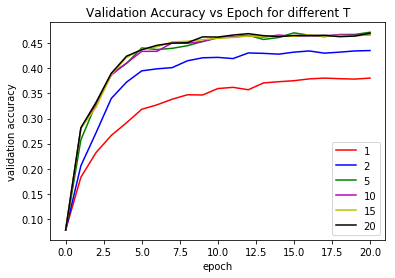

In [16]:
color = ['r', 'b', 'g', 'm', 'y', 'k']
for hparam, c in zip(hparams_list, color):
    cur_results = results_distill[utils.hparamDictToTuple(hparam)]
    plt.plot(cur_results['val_acc'], color=c, label=str(hparam['T']))
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation Accuracy vs Epoch for different T')
plt.savefig(summaries_path_student + 'val_acc_vs_epoch_wrt_T.pdf')

In [ ]:
for hparam in hparams_list:
    load_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    load_dict = torch.load(load_path)
    student_net = networks.StudentNetwork()
    student_net.load_state_dict(load_dict['model_state_dict'])
    student_net = student_net.to(fast_device)
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print(utils.hparamToString(hparam))
    print('test accuracy: ', test_accuracy)
    print('')

#### Effect of alpha

In [ ]:
num_epochs = 20
print_every = 100

In [ ]:
temperatures = [5]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [0.8, 0.5, 0.4, 0.2]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))
    reproducibilitySeed()
    student_net = networks.StudentNetwork()
    student_net = student_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results_distill[hparam_tuple] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs, 
                                                                train_loader, val_loader, 
                                                                print_every=print_every, 
                                                                fast_device=fast_device)
    save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({'results' : results_distill[hparam_tuple], 
                'model_state_dict' : student_net.state_dict(), 
                'epoch' : num_epochs}, save_path)

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 5]
T_scatter = [math.log(h['T']) for h in hparams_list]
alpha_scatter = [h['alpha'] for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results_distill[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(T_scatter, alpha_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(T_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (T_scatter[i], alpha_scatter[i]))
plt.show()

In [ ]:
color = ['r', 'b', 'g', 'm']
for hparam, c in zip(hparams_list, color):
    cur_results = results_distill[utils.hparamDictToTuple(hparam)]
    plt.plot(cur_results['val_acc'], color=c, label=str(hparam['alpha']))
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation Accuracy vs Epoch for different alpha')
plt.savefig(summaries_path_student + 'val_acc_vs_epoch_wrt_alpha.pdf')

In [ ]:
for hparam in hparams_list:
    load_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    load_dict = torch.load(load_path)
    student_net = networks.StudentNetwork()
    student_net.load_state_dict(load_dict['model_state_dict'])
    student_net = student_net.to(fast_device)
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
    print(utils.hparamToString(hparam))
    print('test accuracy: ', test_accuracy)
    print('')